In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.optim import Adam
from tqdm import tqdm

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
EPOCHS = 100

In [3]:
# batch size x channels x time x bands
valid_part = torch.rand((32, 1, 128, 64))

In [4]:
class HeadBlock(nn.Module):
    def __init__(self, input_features: int, output_classes: int):
        super().__init__()

        self.layers = nn.ModuleList(
            [
                nn.Flatten(),
                nn.Linear(input_features, output_classes),
            ]
        )

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

In [5]:
block_test = HeadBlock(8192, 5)
block_test(valid_part).shape

torch.Size([32, 5])

In [6]:
class FeatureExtractionBlock(nn.Module):
    def __init__(
        self,
        input_channels: int,
        output_channels: int,
        conv_kernel_size: int = 3,
        conv_stride: int = 2,
        conv_padding: int = 1,
        pooling_kernel_size: int = 2,
    ):
        super().__init__()

        self.layers = nn.ModuleList(
            [
                nn.Conv2d(
                    input_channels,
                    output_channels,
                    kernel_size=conv_kernel_size,
                    stride=conv_stride,
                    padding=conv_padding,
                ),
                nn.AvgPool2d(kernel_size=pooling_kernel_size),
                nn.BatchNorm2d(output_channels),
            ]
        )

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

In [7]:
extraction_test = FeatureExtractionBlock(1, 32)
extraction_test(valid_part).shape

torch.Size([32, 32, 32, 16])

In [ ]:
class BirdClassifier(nn.Module):
    def __init__(
        self,
        output_classes: int,
        input_channels: int,
        extractor_layers: int,
        validation_tensor: torch.Tensor,
    ):
        super().__init__()
        # Entry extractor
        self.entry_extractor_output_channels = 64
        self.entry_extractor = FeatureExtractionBlock(
            input_channels, self.entry_extractor_output_channels
        )
        self.second_extractor = FeatureExtractionBlock(self.entry_extractor_output_channels, 128)
        self.third_extractor = FeatureExtractionBlock(128, 256)

        output = self.entry_extractor(validation_tensor)
        output = self.second_extractor(output)
        output = self.third_extractor(output)
        

        head_input_features = (
            output.shape[1]
            * output.shape[2]
            * output.shape[3]
        )
        self.head = HeadBlock(head_input_features, output_classes)

    def forward(self, x):
        out = x
        out = self.entry_extractor(x)
        out = self.second_extractor(out)
        out = self.third_extractor(out)
        return self.head(out)

In [9]:
class BirdClassifierManager:
    def __init__(
        self,
        output_classes: int,
        input_channels: int,
        extractor_layers: int,
        validation_tensor: torch.Tensor,
        load_model: bool = False,
        model_path="./bird_classifier.pth",
        device: str = DEVICE
    ):
        self.model_path = model_path
        self.device = device
        if load_model:
            self.load_model()
        else:
            self.model = BirdClassifier(
                output_classes, input_channels, extractor_layers, validation_tensor
            ).to(self.device)

        self.validation_tensor = validation_tensor

    def validate(self):
        try:
            self.model(self.validation_tensor)
            print("OK!")
        except Exception as e:
            print(f"Validation failed: {e}")

    def predict(self, sample: torch.Tensor):
        sample = sample.to(self.device)
        with torch.no_grad():
            return self.model(sample)

    def save_model(self):
        torch.save(self.model, self.model_path)

    def load_model(self):
        self.model.load_state_dict(torch.load(self.model_path))
        self.model.to(self.device)

    def train(self, train: Dataset, valid: Dataset, epochs: int = EPOCHS, lr: float = 0.0001):
        criterion = nn.CrossEntropyLoss()
        optimizer = Adam(self.model.parameters(), lr=lr)

        for epoch in range(epochs):
            self.model.train()
            train_loss = 0.0
            correct_train = 0
            total_train = 0

            for inputs, labels in tqdm(train):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                correct_train += predicted.eq(labels).sum().item()
                total_train += labels.size(0)

            train_loss /= len(train)
            train_accuracy = 100 * correct_train / total_train
            
            if epoch % 5 == 0:
                self.save_model()

            self.model.eval()
            valid_loss = 0.0
            correct_valid = 0
            total_valid = 0

            with torch.no_grad():
                for inputs, labels in valid:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = self.model(inputs)
                    loss = criterion(outputs, labels)
                    
                    valid_loss += loss.item() * inputs.size(0)
                    _, predicted = outputs.max(1)
                    correct_valid += predicted.eq(labels).sum().item()
                    total_valid += labels.size(0)

            valid_loss /= len(valid)
            valid_accuracy = 100 * correct_valid / total_valid

            print(f"Epoch [{epoch+1}/{epochs}] "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% "
                  f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%")

    def test(self, test: Dataset):
        self.model.eval()
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in test:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = outputs.max(1)
                correct_test += predicted.eq(labels).sum().item()
                total_test += labels.size(0)

        test_accuracy = 100 * correct_test / total_test
        print(f"Test Accuracy: {test_accuracy:.2f}%")

In [10]:
import os
import torchaudio
import numpy as np
import pandas as pd
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [11]:
class BirdSongDataset(Dataset):
    def __init__(
        self,
        x: pd.DataFrame,
        y: pd.DataFrame,
        sample_rate: int,
        num_samples: int,
        as_mel_spectogram: bool = True,
    ):
        super().__init__()
        self.x = x
        self.y = y
        self.target_sample_rate = sample_rate
        self.target_number_of_samples = num_samples
        self.as_mel_spectogram = as_mel_spectogram
        self.mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.target_sample_rate, n_fft=1024, hop_length=512, n_mels=64
        )

    def _resample_if_necessary(self, waveform: torch.Tensor, sample_rate: int):
        if sample_rate != self.target_sample_rate:
            resample_transform = torchaudio.transforms.Resample(
                orig_freq=sample_rate, new_freq=self.target_sample_rate
            )
            waveform = resample_transform(waveform)
        return waveform

    def _pad_or_trim(self, waveform: torch.Tensor):
        if waveform.shape[1] > self.target_number_of_samples:
            waveform = waveform[:, : self.target_number_of_samples]
        elif waveform.shape[1] < self.target_number_of_samples:
            padding = self.target_number_of_samples - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))
        return waveform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        path, class_ = self.x[index], self.y[index]

        waveform, sample_rate = torchaudio.load(str(path))
        waveform = self._resample_if_necessary(waveform, sample_rate)
        waveform = self._pad_or_trim(waveform)

        if self.as_mel_spectogram:
            waveform = self.mel_spectrogram_transform(waveform)

        return waveform, class_

In [12]:
class BirdSongDatasetManager:
    def __init__(
        self,
        csv_file_path: Path,
        audio_files_main_folder: Path,
        train: float = 0.8,
        valid: float = 0.1,
        test: float = 0.1,
        batch_size: int = 32,
        shuffle: bool = True,
        csv_file_name: str = "train_mod.csv",
        sample_rate: int = 32000,
        num_samples: int = 160000,
    ):
        if not np.isclose((train + valid + test), 1):
            raise Exception("Sum of dataset partitions must be equal to 1")

        self.csv_file_path = csv_file_path
        self.audio_files_main_folder = audio_files_main_folder
        self.train = train
        self.valid = valid
        self.test = test
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.csv_file_name = csv_file_name
        self.number_of_classes = 0

        self.index_to_class, self.class_to_index = dict(), dict()

        self.dataframe, self.species_to_name = self._filter_data(
            self.csv_file_path, self.audio_files_main_folder
        )
        self.species_in_dataset = self.dataframe["ebird_code"].unique()

        self.mapped_dataframe = self._map_bird_to_path()

        self.dataset_loaders_args = dict(
            sample_rate=sample_rate, num_samples=num_samples
        )

    def _filter_data(
        self, csv_file_path: Path, audio_files_main_folder: Path
    ) -> pd.DataFrame:
        dataframe = pd.read_csv(csv_file_path)

        current_dataset_species = os.listdir(audio_files_main_folder)
        current_dataset_species.remove(self.csv_file_name)

        ebird_code_to_name = dict()
        class_ = 0
        for species in current_dataset_species:
            name = dataframe[dataframe["ebird_code"] == species].iloc[0]["species"]

            self.class_to_index[name] = class_
            self.index_to_class[class_] = name
            ebird_code_to_name[species] = name

            class_ += 1
        
        self.number_of_classes = class_

        return (
            dataframe[dataframe["ebird_code"].isin(current_dataset_species)],
            ebird_code_to_name,
        )

    def _map_bird_to_path(self) -> pd.DataFrame:
        data = []
        for species in self.species_in_dataset:
            prefix = self.audio_files_main_folder / species
            audio_files = os.listdir(prefix)
            for file in audio_files:
                file_path = prefix / file

                class_code = self.species_to_name[species]
                data.append(
                    {
                        "class": self.class_to_index[class_code],
                        "file_path": file_path,
                        "class_name": class_code,
                        "ebird_code": species,
                    }
                )

        return pd.DataFrame(data)

    def get_datasets(self, with_valid: bool = True):
        train_data = []
        valid_data = []
        test_data = []

        for _, group in self.mapped_dataframe.groupby("ebird_code"):
            group = group.sample(frac=1, random_state=42).reset_index(drop=True)
            n = len(group)
            train_end = int(self.train * n)
            valid_end = train_end + int(self.valid * n) if with_valid else train_end

            train_data.append(group.iloc[:train_end])
            if with_valid:
                valid_data.append(group.iloc[train_end:valid_end])
                test_data.append(group.iloc[valid_end:])
            else:
                test_data.append(group.iloc[train_end:])

        train_df = pd.concat(train_data).reset_index(drop=True)
        valid_df = pd.concat(valid_data).reset_index(drop=True) if with_valid else None
        test_df = pd.concat(test_data).reset_index(drop=True)

        train = DataLoader(
            BirdSongDataset(
                train_df["file_path"], train_df["class"], **self.dataset_loaders_args
            ),
            batch_size=self.batch_size,
            shuffle=self.shuffle,
        )
        
        valid = (
            DataLoader(
                BirdSongDataset(
                    valid_df["file_path"],
                    valid_df["class"],
                    **self.dataset_loaders_args
                )
            )
            if with_valid
            else None
        )
        
        test = DataLoader(
            BirdSongDataset(
                test_df["file_path"], test_df["class"], **self.dataset_loaders_args
            )
        )

        return train, valid, test

In [13]:
dataset_manager = BirdSongDatasetManager(Path("data/train_mod.csv"), Path("data"))

In [14]:
train_part, valid_part, test_part = dataset_manager.get_datasets()

In [15]:
x = next(iter(train_part))
x[0].shape, x[1]

(torch.Size([32, 1, 64, 313]),
 tensor([43, 32,  3, 32, 45, 30, 16, 38, 32, 39, 11, 18, 41,  0, 46, 44,  1, 15,
         39, 16, 45, 15, 27, 18,  7, 17, 27, 44, 22,  3, 33,  1]))

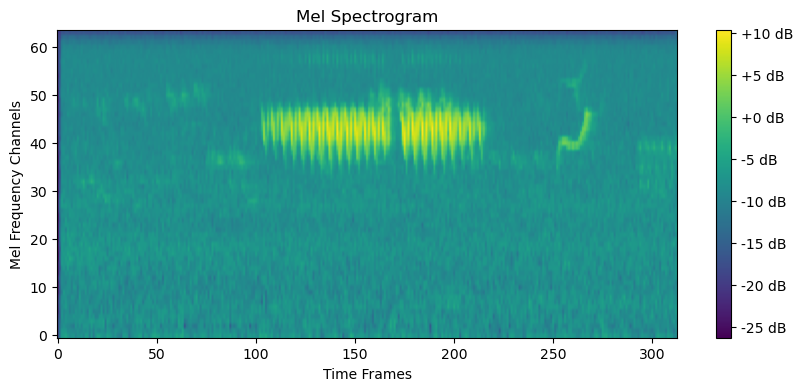

In [16]:
plt.figure(figsize=(10, 4))
plt.imshow(x[0][5].log2()[0, :, :].numpy(), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram")
plt.xlabel("Time Frames")
plt.ylabel("Mel Frequency Channels")
plt.show()

In [17]:
valid = x[0]
model_manager = BirdClassifierManager(dataset_manager.number_of_classes, 1, 2, valid)
model_manager.validate()
model_manager.predict(valid).shape

Validation failed: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor


torch.Size([32, 47])

In [18]:
model_manager.train(train_part, valid_part)

100%|██████████| 98/98 [01:17<00:00,  1.27it/s]


Epoch [1/100] Train Loss: 124.0788, Train Acc: 3.48% Valid Loss: 3.8242, Valid Acc: 4.46%


100%|██████████| 98/98 [01:21<00:00,  1.21it/s]


Epoch [2/100] Train Loss: 117.5436, Train Acc: 8.17% Valid Loss: 3.7628, Valid Acc: 7.09%


100%|██████████| 98/98 [01:23<00:00,  1.18it/s]


Epoch [3/100] Train Loss: 114.3669, Train Acc: 11.17% Valid Loss: 3.7397, Valid Acc: 8.40%


100%|██████████| 98/98 [01:22<00:00,  1.18it/s]


Epoch [4/100] Train Loss: 111.6504, Train Acc: 13.41% Valid Loss: 3.7026, Valid Acc: 9.97%


100%|██████████| 98/98 [02:00<00:00,  1.23s/it]


Epoch [5/100] Train Loss: 109.8975, Train Acc: 15.42% Valid Loss: 3.6957, Valid Acc: 11.02%


100%|██████████| 98/98 [01:26<00:00,  1.13it/s]


Epoch [6/100] Train Loss: 108.2428, Train Acc: 17.08% Valid Loss: 3.6813, Valid Acc: 10.76%


100%|██████████| 98/98 [01:22<00:00,  1.19it/s]


Epoch [7/100] Train Loss: 107.0711, Train Acc: 17.01% Valid Loss: 3.6683, Valid Acc: 9.97%


100%|██████████| 98/98 [01:27<00:00,  1.13it/s]


Epoch [8/100] Train Loss: 105.4334, Train Acc: 19.95% Valid Loss: 3.6519, Valid Acc: 9.71%


100%|██████████| 98/98 [01:23<00:00,  1.17it/s]


Epoch [9/100] Train Loss: 104.6746, Train Acc: 20.20% Valid Loss: 3.6674, Valid Acc: 11.29%


100%|██████████| 98/98 [01:34<00:00,  1.04it/s]


Epoch [10/100] Train Loss: 103.3835, Train Acc: 21.45% Valid Loss: 3.6419, Valid Acc: 10.50%


100%|██████████| 98/98 [01:31<00:00,  1.07it/s]


Epoch [11/100] Train Loss: 102.2224, Train Acc: 21.96% Valid Loss: 3.6428, Valid Acc: 12.86%


100%|██████████| 98/98 [01:26<00:00,  1.14it/s]


Epoch [12/100] Train Loss: 101.3001, Train Acc: 22.79% Valid Loss: 3.6414, Valid Acc: 12.60%


100%|██████████| 98/98 [01:23<00:00,  1.17it/s]


Epoch [13/100] Train Loss: 100.4420, Train Acc: 24.19% Valid Loss: 3.6506, Valid Acc: 13.39%


100%|██████████| 98/98 [01:31<00:00,  1.07it/s]


Epoch [14/100] Train Loss: 99.4746, Train Acc: 25.31% Valid Loss: 3.6348, Valid Acc: 13.12%


100%|██████████| 98/98 [01:24<00:00,  1.17it/s]


Epoch [15/100] Train Loss: 98.8804, Train Acc: 25.66% Valid Loss: 3.6542, Valid Acc: 12.60%


100%|██████████| 98/98 [01:26<00:00,  1.13it/s]


Epoch [16/100] Train Loss: 98.1941, Train Acc: 26.30% Valid Loss: 3.6513, Valid Acc: 11.55%


100%|██████████| 98/98 [01:23<00:00,  1.18it/s]


Epoch [17/100] Train Loss: 97.2949, Train Acc: 27.77% Valid Loss: 3.6522, Valid Acc: 12.34%


100%|██████████| 98/98 [01:22<00:00,  1.19it/s]


Epoch [18/100] Train Loss: 96.5816, Train Acc: 27.90% Valid Loss: 3.6400, Valid Acc: 11.02%


100%|██████████| 98/98 [01:24<00:00,  1.16it/s]


Epoch [19/100] Train Loss: 95.9512, Train Acc: 28.79% Valid Loss: 3.6612, Valid Acc: 11.81%


100%|██████████| 98/98 [01:24<00:00,  1.17it/s]


Epoch [20/100] Train Loss: 94.9834, Train Acc: 29.05% Valid Loss: 3.6716, Valid Acc: 12.86%


100%|██████████| 98/98 [01:24<00:00,  1.16it/s]


Epoch [21/100] Train Loss: 94.5174, Train Acc: 29.75% Valid Loss: 3.6433, Valid Acc: 13.12%


100%|██████████| 98/98 [01:26<00:00,  1.14it/s]


Epoch [22/100] Train Loss: 93.9854, Train Acc: 30.16% Valid Loss: 3.6654, Valid Acc: 13.65%


100%|██████████| 98/98 [01:23<00:00,  1.17it/s]


Epoch [23/100] Train Loss: 93.2770, Train Acc: 30.64% Valid Loss: 3.6575, Valid Acc: 12.60%


100%|██████████| 98/98 [01:23<00:00,  1.17it/s]


Epoch [24/100] Train Loss: 92.4626, Train Acc: 31.69% Valid Loss: 3.6791, Valid Acc: 11.55%


100%|██████████| 98/98 [01:24<00:00,  1.16it/s]


Epoch [25/100] Train Loss: 91.8654, Train Acc: 32.56% Valid Loss: 3.6760, Valid Acc: 14.17%


100%|██████████| 98/98 [01:21<00:00,  1.20it/s]


Epoch [26/100] Train Loss: 91.3356, Train Acc: 32.59% Valid Loss: 3.6960, Valid Acc: 13.65%


100%|██████████| 98/98 [01:22<00:00,  1.19it/s]


Epoch [27/100] Train Loss: 90.8583, Train Acc: 33.07% Valid Loss: 3.6848, Valid Acc: 13.39%


100%|██████████| 98/98 [01:25<00:00,  1.15it/s]


Epoch [28/100] Train Loss: 90.1106, Train Acc: 33.58% Valid Loss: 3.7170, Valid Acc: 12.86%


100%|██████████| 98/98 [01:23<00:00,  1.18it/s]


Epoch [29/100] Train Loss: 89.8747, Train Acc: 33.04% Valid Loss: 3.7286, Valid Acc: 13.39%


100%|██████████| 98/98 [01:23<00:00,  1.17it/s]


Epoch [30/100] Train Loss: 89.3115, Train Acc: 34.70% Valid Loss: 3.7220, Valid Acc: 11.81%


100%|██████████| 98/98 [01:35<00:00,  1.03it/s]


Epoch [31/100] Train Loss: 88.7989, Train Acc: 34.57% Valid Loss: 3.8265, Valid Acc: 14.44%


100%|██████████| 98/98 [01:23<00:00,  1.18it/s]


Epoch [32/100] Train Loss: 88.2064, Train Acc: 35.56% Valid Loss: 3.7349, Valid Acc: 13.39%


100%|██████████| 98/98 [01:26<00:00,  1.13it/s]


Epoch [33/100] Train Loss: 87.9050, Train Acc: 35.49% Valid Loss: 3.7865, Valid Acc: 12.07%


100%|██████████| 98/98 [01:24<00:00,  1.15it/s]


Epoch [34/100] Train Loss: 87.0872, Train Acc: 36.71% Valid Loss: 3.6884, Valid Acc: 12.86%


100%|██████████| 98/98 [01:25<00:00,  1.15it/s]


Epoch [35/100] Train Loss: 86.8869, Train Acc: 37.31% Valid Loss: 3.7802, Valid Acc: 14.70%


100%|██████████| 98/98 [01:24<00:00,  1.16it/s]


Epoch [36/100] Train Loss: 86.1672, Train Acc: 36.67% Valid Loss: 3.7107, Valid Acc: 12.34%


100%|██████████| 98/98 [01:27<00:00,  1.12it/s]


Epoch [37/100] Train Loss: 85.9058, Train Acc: 37.50% Valid Loss: 3.6913, Valid Acc: 11.81%


100%|██████████| 98/98 [01:25<00:00,  1.15it/s]


Epoch [38/100] Train Loss: 85.1990, Train Acc: 38.08% Valid Loss: 3.7970, Valid Acc: 12.86%


100%|██████████| 98/98 [01:26<00:00,  1.14it/s]


Epoch [39/100] Train Loss: 84.4451, Train Acc: 38.84% Valid Loss: 3.8072, Valid Acc: 14.96%


100%|██████████| 98/98 [01:23<00:00,  1.18it/s]


Epoch [40/100] Train Loss: 83.9992, Train Acc: 38.62% Valid Loss: 3.7840, Valid Acc: 12.07%


100%|██████████| 98/98 [01:26<00:00,  1.13it/s]


Epoch [41/100] Train Loss: 83.8152, Train Acc: 39.10% Valid Loss: 3.8273, Valid Acc: 13.91%


100%|██████████| 98/98 [01:28<00:00,  1.10it/s]


Epoch [42/100] Train Loss: 83.4019, Train Acc: 39.74% Valid Loss: 3.7979, Valid Acc: 14.96%


100%|██████████| 98/98 [01:29<00:00,  1.10it/s]


Epoch [43/100] Train Loss: 82.9064, Train Acc: 39.67% Valid Loss: 3.9158, Valid Acc: 12.60%


 46%|████▌     | 45/98 [00:37<00:44,  1.20it/s]


KeyboardInterrupt: 